<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S11/blob/main/S11_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages

In [1]:
%%capture
!pip install torch-lr-finder
!pip install grad-cam

In [2]:
%%capture
!git clone https://github.com/sayanbanerjee32/TASI_vision_master.git

# Import all required packages including local files

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np

#import from local modules
from TASI_vision_master.data_prep.cifar10.aug_dataloader import get_data_loader
from TASI_vision_master.train import train_orchestrator, lr_range_test
from TASI_vision_master.utils import get_device, plot_accuracy_losses, plot_top_loss, plot_image, get_mean_and_std
from TASI_vision_master.models.resnet import ResNet18

# Check if GPU available

In [4]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Check for dataset mean and standard deviation

In [5]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 49195540.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
# # train data shape
# print(train_data_raw.data.shape)
# # train data mean
# print(train_data_raw.data.mean(axis=(0,1,2))/train_data_raw.data.max())
# # train data standard deviation
# print(train_data_raw.data.std(axis=(0,1,2))/train_data_raw.data.max())

In [7]:
mean, std = get_mean_and_std(train_data_raw)
mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

# Dataloader Arguments & Test/Train Dataloaders

In [8]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

train_loader = get_data_loader(dataloader_args = dataloader_args)
test_loader = get_data_loader(dataloader_args = dataloader_args, is_train = False)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


### Augmented data visualization

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])


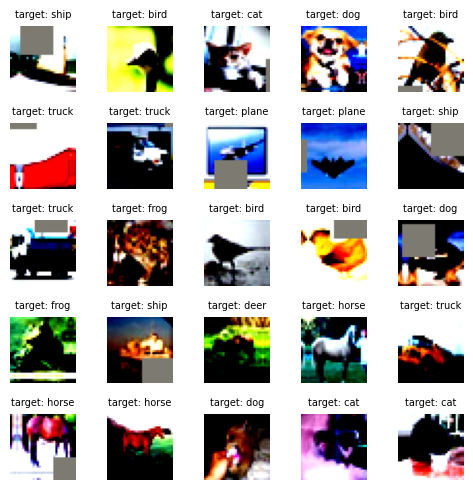

In [10]:
plot_image(images.permute(0, 2, 3, 1).numpy(), [class_labels[l] for l in labels])

# Training

In [11]:
# visualise model parameters
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.85E-01


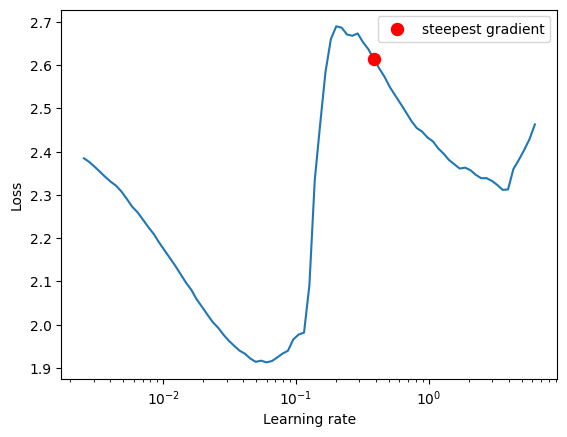

In [12]:
## LR range test
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9)
criterion = F.cross_entropy
lr_range_test(model, optimizer, criterion, train_loader, device)

In [13]:
## train model
num_epochs = 20
LRMAX = 3.85E-01
LRMIN = LRMAX/10
scheduler = optim.lr_scheduler.OneCycleLR(optimizer  = optimizer, max_lr = LRMAX,
                                          anneal_strategy = 'linear',
                                          pct_start=0.4, div_factor=10,final_div_factor = 1,
                                          steps_per_epoch=len(train_loader), epochs=num_epochs,
                                          three_phase = False)

train_history_dict = train_orchestrator(model, device, train_loader, test_loader,
                                        criterion, optimizer, scheduler,
                                        learning_rate = LRMIN, num_epochs = num_epochs)

Epoch 1


Train: Loss=1.4617 Batch_id=97 Accuracy=34.84: 100%|██████████| 98/98 [00:36<00:00,  2.68it/s]


Test set: Average loss: 1.7405, Accuracy: 4241/10000 (42.41%)

Learning rate updated to: 0.08186781609195402
Epoch 2


Train: Loss=1.2527 Batch_id=97 Accuracy=52.98: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 1.2554, Accuracy: 5483/10000 (54.83%)

Learning rate updated to: 0.12523563218390804
Epoch 3


Train: Loss=1.0537 Batch_id=97 Accuracy=62.78: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 1.4283, Accuracy: 5650/10000 (56.50%)

Learning rate updated to: 0.1686034482758621
Epoch 4


Train: Loss=0.8009 Batch_id=97 Accuracy=70.41: 100%|██████████| 98/98 [00:37<00:00,  2.65it/s]


Test set: Average loss: 0.8200, Accuracy: 7229/10000 (72.29%)

Learning rate updated to: 0.2119712643678161
Epoch 5


Train: Loss=0.5773 Batch_id=97 Accuracy=74.88: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.7132, Accuracy: 7616/10000 (76.16%)

Learning rate updated to: 0.2553390804597701
Epoch 6


Train: Loss=0.7514 Batch_id=97 Accuracy=78.04: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.6963, Accuracy: 7580/10000 (75.80%)

Learning rate updated to: 0.29870689655172417
Epoch 7


Train: Loss=0.5386 Batch_id=97 Accuracy=80.61: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.5919, Accuracy: 7926/10000 (79.26%)

Learning rate updated to: 0.34207471264367817
Epoch 8


Train: Loss=0.5209 Batch_id=97 Accuracy=82.54: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test set: Average loss: 0.6288, Accuracy: 7953/10000 (79.53%)

Learning rate updated to: 0.38470535714285714
Epoch 9


Train: Loss=0.4640 Batch_id=97 Accuracy=84.19: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.4918, Accuracy: 8305/10000 (83.05%)

Learning rate updated to: 0.35583035714285716
Epoch 10


Train: Loss=0.3648 Batch_id=97 Accuracy=85.61: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.4445, Accuracy: 8522/10000 (85.22%)

Learning rate updated to: 0.3269553571428572
Epoch 11


Train: Loss=0.3947 Batch_id=97 Accuracy=87.18: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.4285, Accuracy: 8582/10000 (85.82%)

Learning rate updated to: 0.29808035714285713
Epoch 12


Train: Loss=0.3051 Batch_id=97 Accuracy=88.26: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.5031, Accuracy: 8393/10000 (83.93%)

Learning rate updated to: 0.26920535714285715
Epoch 13


Train: Loss=0.3001 Batch_id=97 Accuracy=89.25: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.3902, Accuracy: 8668/10000 (86.68%)

Learning rate updated to: 0.24033035714285714
Epoch 14


Train: Loss=0.2676 Batch_id=97 Accuracy=90.00: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.4458, Accuracy: 8533/10000 (85.33%)

Learning rate updated to: 0.21145535714285713
Epoch 15


Train: Loss=0.2476 Batch_id=97 Accuracy=90.77: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.4065, Accuracy: 8727/10000 (87.27%)

Learning rate updated to: 0.18258035714285714
Epoch 16


Train: Loss=0.3060 Batch_id=97 Accuracy=91.47: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.3496, Accuracy: 8847/10000 (88.47%)

Learning rate updated to: 0.15370535714285713
Epoch 17


Train: Loss=0.1627 Batch_id=97 Accuracy=92.48: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.3405, Accuracy: 8890/10000 (88.90%)

Learning rate updated to: 0.12483035714285712
Epoch 18


Train: Loss=0.2349 Batch_id=97 Accuracy=93.35: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.3089, Accuracy: 9007/10000 (90.07%)

Learning rate updated to: 0.09595535714285713
Epoch 19


Train: Loss=0.1491 Batch_id=97 Accuracy=93.86: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test set: Average loss: 0.3392, Accuracy: 8989/10000 (89.89%)

Learning rate updated to: 0.06708035714285715
Epoch 20


Train: Loss=0.0952 Batch_id=97 Accuracy=94.84: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.3016, Accuracy: 9088/10000 (90.88%)

Learning rate updated to: 0.03820535714285711


In [14]:
# final learning rate
scheduler.get_last_lr()

[0.03820535714285711]

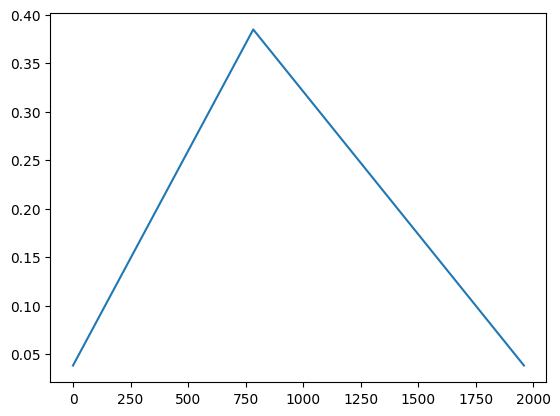

In [15]:
# lr update history
plt.plot(train_history_dict['lr_list'])

## Visualise training and test losses and accuracies

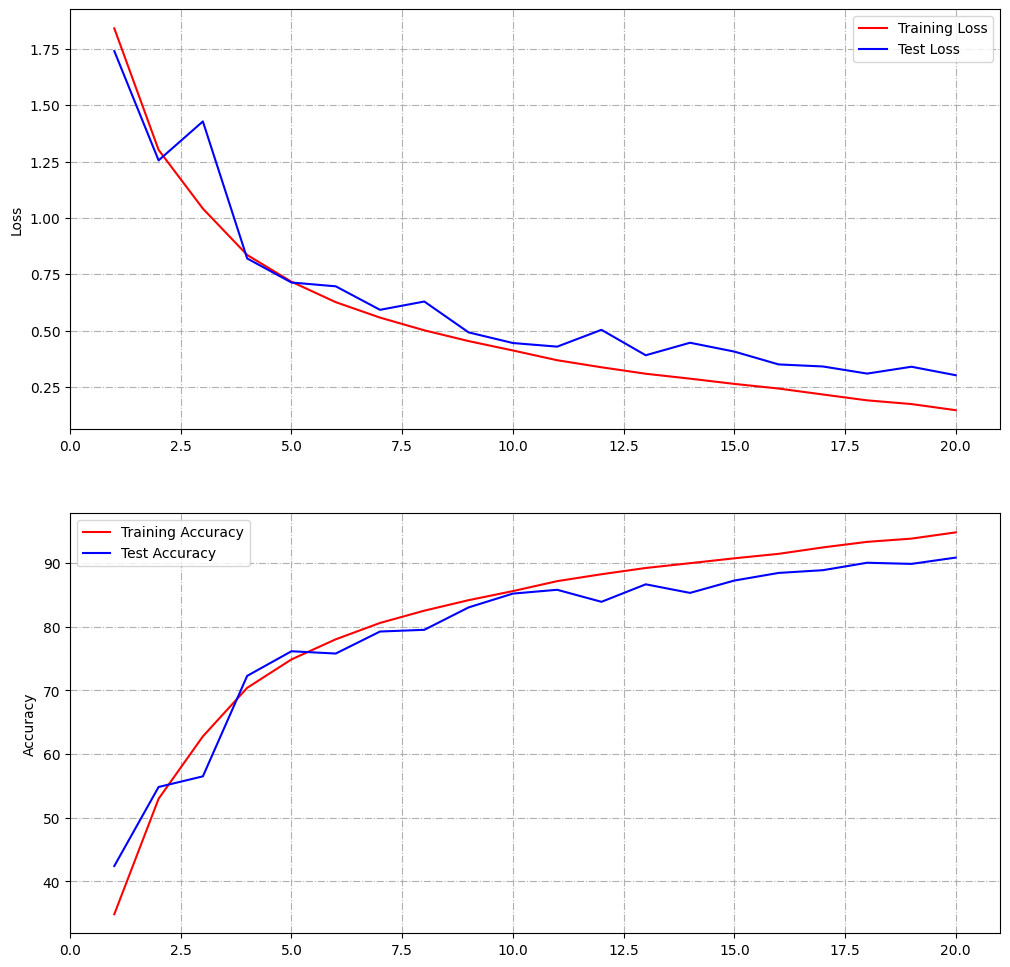

In [16]:
## use function from utils.py
plot_accuracy_losses(train_history_dict['train_losses'],
                     train_history_dict['train_acc'],
                     train_history_dict['test_losses'],
                     train_history_dict['test_acc'],
                     train_history_dict['best_epoch'])

## Error analysis

In [17]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# def get_gradcam_image(model, target_layers, input_tensor, rgb_img, cam_target, cam_batch_size = 64):
#     cam = GradCAM(model=model, target_layers=target_layers)
#     cam.batch_size = cam_batch_size
#     targets = [ClassifierOutputTarget(cam_target)]
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

#     # In this example grayscale_cam has only one image in the batch:
#     grayscale_cam = grayscale_cam[0, :]
#     visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

#     # You can also get the model outputs without having to re-inference
#     return cam.outputs, visualization


In [18]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# def plot_confusion_matrix(actual, predicted ):
#     cm = confusion_matrix(actual,predicted)
#     sns.heatmap(cm,
#             annot=True,
#             fmt='g',
#             xticklabels=sorted(list(set(actual))),
#             yticklabels=sorted(list(set(actual)))
#             )
#     plt.yticks(rotation=0)
#     plt.ylabel('Prediction',fontsize=13)
#     plt.xlabel('Actual',fontsize=13)
#     plt.title('Confusion Matrix',fontsize=17)
#     plt.show()

In [19]:
# import pandas as pd
# # get predicted value based on argmax
# def GetPrediction(pPrediction):
#   return pPrediction.argmax(dim=1)


# # Returns individual image with target, prediction and loss
# # after batch inference
# def get_individual_loss(model, device, data_loader, criterion):
#     # switching on eval / test mode
#     model.eval()

#     loss_list = []


#     # no gradient calculation is required for test
#     ## as parameters are not updated while test
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(data_loader):
#             data, target = data.to(device), target.to(device)

#             output = model(data)

#             for d,t,p,l in zip(data, target,
#                                GetPrediction(output),
#                                criterion(output, target, reduction='none')):
#                 loss_list.append((d.to('cpu'),
#                                   t.to('cpu').item(),
#                                   p.to('cpu').item(),
#                                   l.to('cpu').item()))


#     return loss_list
# # the following function will plot images with target and predicted values
# # where prediction is wrong - this will be in order or decreasing loss
# # group by target
# def plot_top_loss(model, device, data_loader, criterion,
#                   label_names = None, img_rows = 5, img_cols = 5,
#                   mean = [0.4914,0.4822,0.4465],
#                   std = [0.247,0.243,0.262],
#                   need_grad_cam_image = False,
#                   target_layers = None,
#                   plot_TP = True):
#     loss_list = get_individual_loss(model, device, data_loader, criterion)
#     loss_df = pd.DataFrame(loss_list, columns=['transform_image', 'target', 'prediction', 'loss'])

#     if label_names is not None:
#         loss_df['target_name'] = loss_df['target'].apply(lambda x: label_names[x])
#         loss_df['prediction_name'] = loss_df['prediction'].apply(lambda x: label_names[x])

#     ## plot confusion matrix
#     plot_confusion_matrix(actual = loss_df['target_name'].to_list(),
#                           predicted =  loss_df['prediction_name'].to_list())

#     loss_df['image'] = loss_df['transform_image'].apply(lambda img: inverse_normalize(img,
#                                                                                 mean, std).permute(1, 2, 0).numpy())

#     # correct
#     if plot_TP:
#         correct_df = loss_df[loss_df.prediction == loss_df.target]
#         print(f"total correct predictions: {correct_df.shape[0]}")
#         correct_df = correct_df.sort_values(by='loss', ascending=True)
#         if need_grad_cam_image: plot_grad_cam_image(model = model,
#                                                 target_layers = target_layers,
#                                                 input_tensors = correct_df['transform_image'].to_list(),
#                                                 images = correct_df['image'].to_list(),
#                                                 cam_targets = correct_df['prediction'].to_list(),
#                                                 target_labels= correct_df['target_name'].to_list(),
#                                                 pred_labels= correct_df['prediction_name'].to_list(),
#                                                 losses = correct_df['loss'].to_list(),
#                                                 rows = img_rows, cols = img_cols)
#         else: plot_image(images = correct_df['image'].to_list(),
#                 target_labels= correct_df['target_name'].to_list(),
#                 pred_labels= correct_df['prediction_name'].to_list(),
#                 losses = correct_df['loss'].to_list(),
#                 rows = img_rows, cols = img_cols)

#     # incorrect - default behaviour
#     incorrect_df = loss_df[loss_df.prediction != loss_df.target]
#     print(f"total wrong predictions: {incorrect_df.shape[0]}")

#     incr_groups = incorrect_df.groupby(['target_name','prediction_name']).agg({'loss':'median',
#                                                              'image':'count'}).reset_index().sort_values(by='image', ascending=False)

#     incorrect_df = incorrect_df.sort_values(by='loss', ascending=False)
#     if need_grad_cam_image: plot_grad_cam_image(model = model,
#                                                 target_layers = target_layers,
#                                                 input_tensors = incorrect_df['transform_image'].to_list(),
#                                                 images = incorrect_df['image'].to_list(),
#                                                 cam_targets = incorrect_df['prediction'].to_list(),
#                                                 target_labels= incorrect_df['target_name'].to_list(),
#                                                 pred_labels= incorrect_df['prediction_name'].to_list(),
#                                                 losses = incorrect_df['loss'].to_list(),
#                                                 rows = img_rows, cols = img_cols)
#     else: plot_image(images = incorrect_df['image'].to_list(),
#                target_labels= incorrect_df['target_name'].to_list(),
#                pred_labels= incorrect_df['prediction_name'].to_list(),
#                losses = incorrect_df['loss'].to_list(),
#                rows = img_rows, cols = img_cols)
#     return incr_groups

# def plot_image(images, target_labels, pred_labels = None, losses = None, rows = 5, cols = 5,
#                img_size=(5,5), font_size = 7):
#     figure = plt.figure(figsize=img_size)
#     for index in range(cols * rows):
#         plt.subplot(rows, cols, index+1)
#         if pred_labels is not None and losses is not None:
#             plt.title(f'target: {target_labels[index]}\nprediction: {pred_labels[index]}\nloss: {round(losses[index],2)}',
#                   fontsize = font_size)
#         else:
#             plt.title(f'target: {target_labels[index]}', fontsize = font_size)
#         plt.axis('off')
#         plt.imshow(images[index])
#     figure.tight_layout()
#     plt.show()

# def plot_grad_cam_image(model, target_layers, input_tensors, images, cam_targets, target_labels,
#                         pred_labels = None, losses = None, rows = 5, cols = 5,
#                img_size=(5,5), font_size = 7):
#     ## create grad_cam
#     cam_op_list = []
#     cam_v_list = []
#     for i in range(rows*cols):
#         c, v = get_gradcam_image(model,
#                   target_layers = target_layers,
#                   input_tensor = input_tensors[i].unsqueeze(0),
#                   rgb_img = images[i],
#                   cam_target = cam_targets[i])
#         cam_op_list.append(c)
#         cam_v_list.append(v)

#     figure = plt.figure(figsize=img_size)
#     for index in range(cols * rows):
#         plt.subplot(rows, cols, index+1)
#         if pred_labels is not None and losses is not None:
#             plt.title(f'target: {target_labels[index]}\nprediction: {pred_labels[index]}\nloss: {round(losses[index],2)}',
#                   fontsize = font_size)
#         else:
#             plt.title(f'target: {target_labels[index]}', fontsize = font_size)
#         plt.axis('off')
#         plt.imshow(cam_v_list[index])
#     figure.tight_layout()
#     plt.show()

# def inverse_normalize(tensor, mean, std):

#     inv_normalize = transforms.Normalize(
#                     mean= [-m/s for m, s in zip(mean, std)],
#                 std= [1/s for s in std]
#                 )
#     return inv_normalize(tensor)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


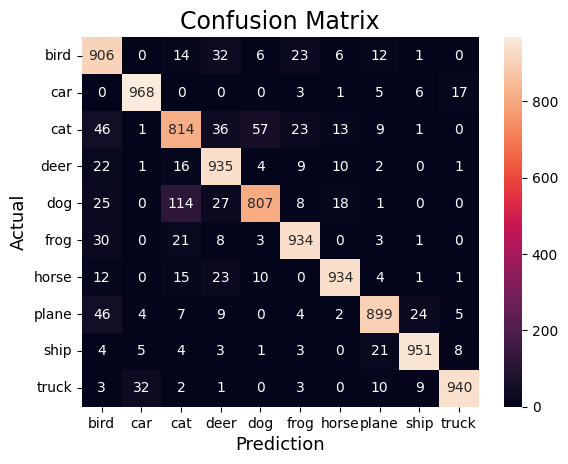

total correct predictions: 9088


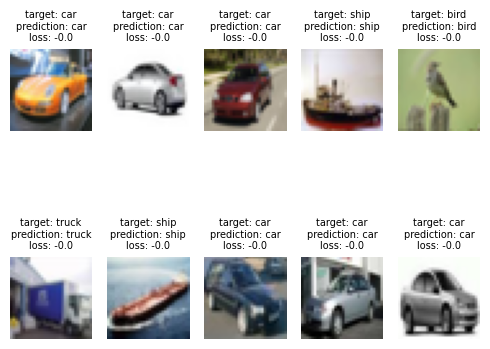

total wrong predictions: 912


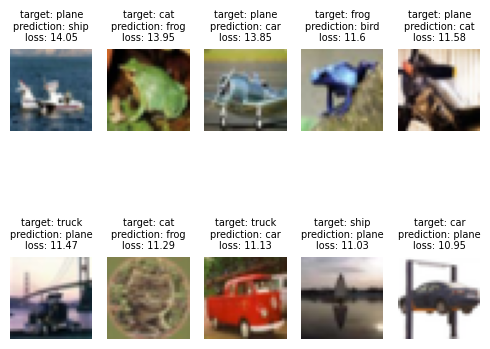

In [24]:
# ## top test images with large losses
_  = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5)

In [21]:
# c, v = get_gradcam_image(model,
#                   target_layers = model.layer3 , #8x8
#                   input_tensor = incorrect_df.iloc[1]['transform_image'].unsqueeze(0),
#                   rgb_img = incorrect_df.iloc[1]['image'],
#                   target = incorrect_df.iloc[1]['target'])

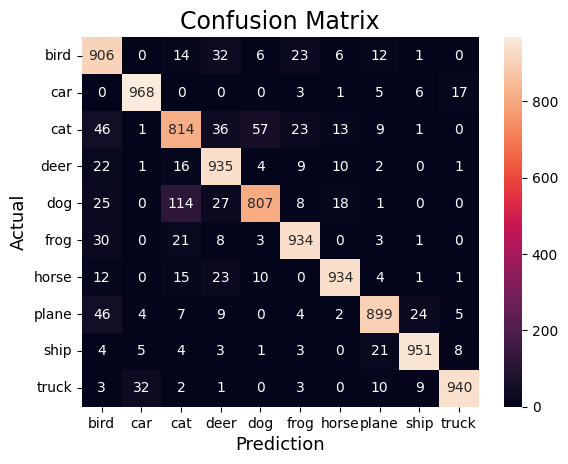

total correct predictions: 9088


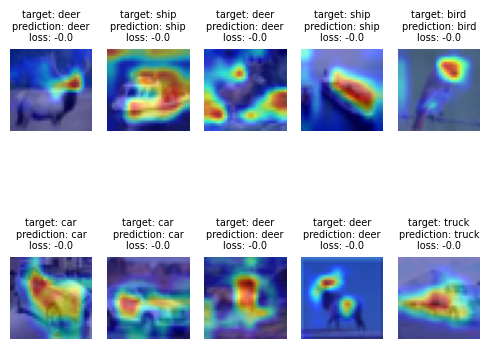

total wrong predictions: 912


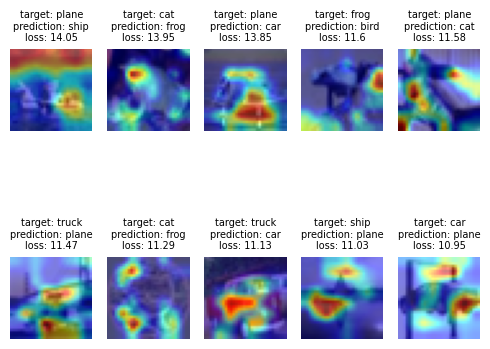

In [22]:
# grad cam images
incr_groups_df  = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5,
                                              need_grad_cam_image= True, target_layers = model.layer3)

In [23]:
## most confusing combinations
incr_groups_df.loc[incr_groups_df.image > 1]

,target_name,prediction_name,loss,image
29,dog,cat,1.887390,114
15,cat,dog,1.494807,57
47,plane,bird,1.630577,46
12,cat,bird,1.972941,46
14,cat,deer,1.829370,36
64,truck,car,2.496313,32
1,bird,deer,1.680334,32
34,frog,bird,2.026790,30
30,dog,deer,2.772808,27
28,dog,bird,2.944981,25
